In [1]:
import numpy as np
from Models import diffusion_advection
from scipy.optimize import least_squares
from Simulation import simulate
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.stats import loguniform

In [2]:
# Fast model using njit
# Model code to run 
import numpy as np
from collections import namedtuple

params = namedtuple('params', ["b_u", "b_l", "g", "c", "d", "p_u", "p_l", "gamma", "k", "f", "r", "D", "a"])
def model(y, t, p):
    # Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
    # States are U1, E1, I1, V1, U2, E2, I2, V2, X
    p = params(*p)
    dydt = np.zeros(len(y)) + 0.0
    #dSu/dt = beta_u*Su*Vu
    dydt[0] = - p.b_u*y[0]*y[3]
    #dEu/dt = beta_u*Su*Vu - g*Eu
    dydt[1] = p.b_u*y[0]*y[3] - p.g*y[1]
    #dIu/dt = g*Eu - d*Iu
    dydt[2] = p.g*y[1] - p.d*y[2]
    #dVu/dt = p_u*Iu - c*Vu - gamma*beta_u*Su*Vu - D*(Vu-Vl) + a*Vl
    dydt[3] = p.p_u*y[2] - p.c*y[3] - p.gamma*p.b_u*y[0]*y[3] - p.D*(y[3]-y[7]) + p.a*y[7]
    #dSl/dt = -beta_l*Sl*Vl
    dydt[4] = - p.b_l*y[4]*y[7]
    #dEl/dt = beta_l*Sl*Vl - g*El
    dydt[5] = p.b_l*y[4]*y[7] - p.g*y[5]
    #dIl/dt = g*El - d*Il
    dydt[6] = p.g*y[5] - p.d*y[6]
    #dVl/dt = p_l*Il - c*Vl - gamma*beta_l*Sl*Il - k*Vl*X + D*(Vu-Vl) - a*Vl
    dydt[7] = p.p_l*y[6] - p.c*y[7] - p.gamma*p.b_l*y[4]*y[7] - p.k*y[7]*y[8] + p.D*(y[3]-y[7]) - p.a*y[7]
    #dX/dt = f*Vl + r*X
    dydt[8] = p.f*y[7] + p.r*y[8]
    return dydt

In [36]:
def sol_minimiser(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3] + results[x,7]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return y - Lresults

def log_minimiser(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3] + results[x,7]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return np.log(y)-np.log(Lresults)

In [4]:
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
p = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/(Cell_Count_U), 5e7/(Cell_Count_L), 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

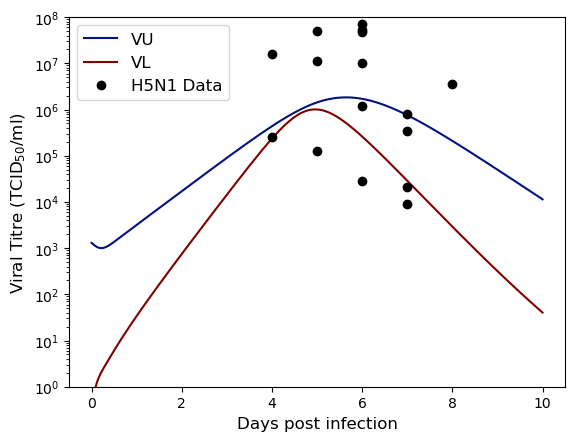

Objective: 6096978652493704.0
Parameters: [7.20981900e-07 1.40844049e-06 1.25000605e-01 7.99993542e-03
 9.99998750e-03 1.00000049e-01]


In [46]:
testls = least_squares(sol_minimiser, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0.01,0.1],bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testls.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testls.cost}")
print(f"Parameters: {testls.x}")

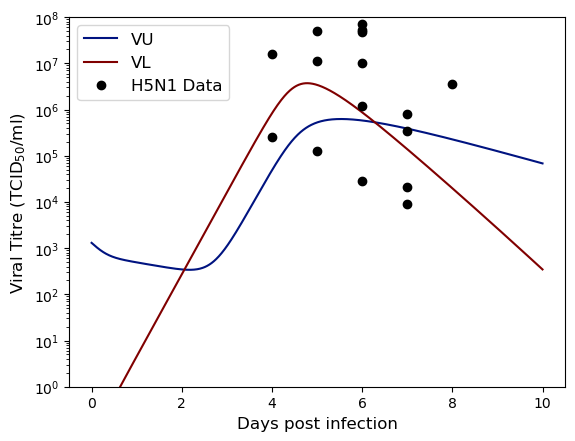

Objective: 61.684776406925494
Parameters: [1.36966700e-07 1.78210914e-07 1.26848484e-01 1.07864165e-01
 8.33441413e-04 3.12023813e-01]


In [48]:
test = least_squares(log_minimiser, x0=[1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0.01,0.1],bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = test.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {test.cost}")
print(f"Parameters: {test.x}")

In [39]:
def sol_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return y - Lresults

def log_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return np.log(y)-np.log(Lresults)

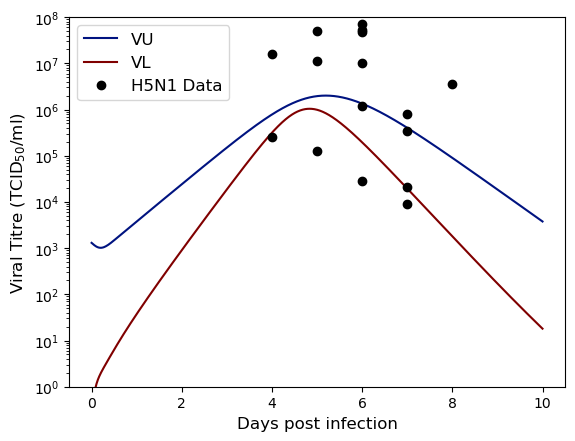

Objective: 6229947047192761.0
Parameters: [8.00397981e-07 1.45431595e-06 1.24997474e-01 7.99985965e-03
 9.99987643e-03 1.00004439e-01]


In [49]:
testlsu = least_squares(sol_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0.01,0.1],bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testlsu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testlsu.cost}")
print(f"Parameters: {testlsu.x}")

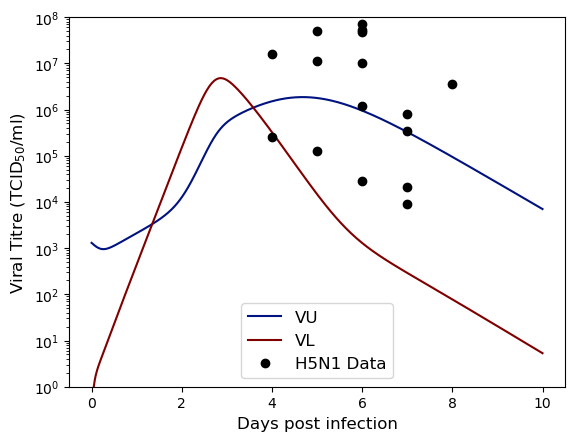

Objective: 66.41734775740846
Parameters: [5.19033145e-07 8.06133054e-07 1.31503929e-01 4.35601179e-02
 1.74771763e-02 2.30708592e-01]


In [51]:
testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0.01,0.1],bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

In [81]:
def everything_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (theta,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return y - Lresults

def everything_log_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (theta,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return np.log(y)-np.log(Lresults)

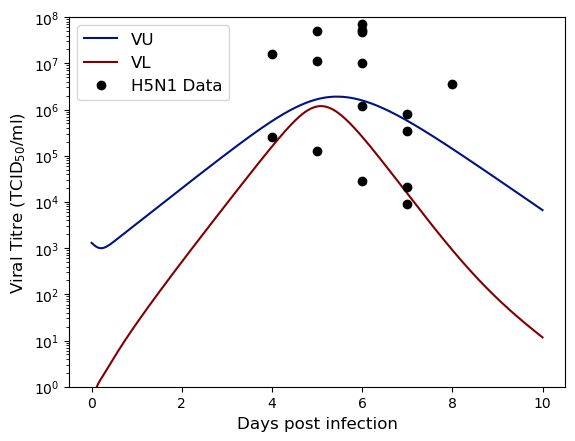

Objective: 6208163287210786.0
Parameters: [7.71631973e-07 2.41511290e-06 3.99999905e+00 1.99999950e+00
 5.20000005e+00 1.24998974e-01 8.00100893e-03 2.49335093e-04
 2.00000000e+01 1.92095424e-07 3.85714275e-02 9.99998909e-03
 1.00000576e-01]


In [82]:
x0 = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/Cell_Count_U, 5e7/Cell_Count_L, 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]
teste = least_squares(everything_minimiser_vu, x0,bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = teste.x
p = theta
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {teste.cost}")
print(f"Parameters: {teste.x}")

In [83]:
diff = teste.x - x0
print(f"b_u: {diff[0]/x0[0]}, b_l: {diff[1]/x0[1]}, g: {diff[2]/x0[2]}, c: {diff[3]/x0[3]}, d: {diff[4]/x0[4]}, p_u: {diff[5]/x0[5]}, p_l: {diff[6]/x0[6]}, gamma: {diff[7]/x0[7]}, k: {diff[8]/x0[8]}, f: {diff[9]/x0[9]}, r: {diff[10]/x0[10]}, D: {diff[11]/x0[11]}, a: {diff[12]/x0[12]}")

b_u: 50.442131510107195, b_l: 0.6100752681277376, g: -2.3761274225986284e-07, c: -2.4878915172443783e-07, d: 9.596747670041868e-09, p_u: -8.20489371800015e-06, p_l: 0.00012611678934927421, gamma: inf, k: -1.746447075845481e-09, f: -0.1424311448059795, r: -2.7591141023143426e-08, D: -1.0911367307950282e-06, a: 5.759777591124449e-06


/tmp/ipykernel_134563/1491180799.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"b_u: {diff[0]/x0[0]}, b_l: {diff[1]/x0[1]}, g: {diff[2]/x0[2]}, c: {diff[3]/x0[3]}, d: {diff[4]/x0[4]}, p_u: {diff[5]/x0[5]}, p_l: {diff[6]/x0[6]}, gamma: {diff[7]/x0[7]}, k: {diff[8]/x0[8]}, f: {diff[9]/x0[9]}, r: {diff[10]/x0[10]}, D: {diff[11]/x0[11]}, a: {diff[12]/x0[12]}")


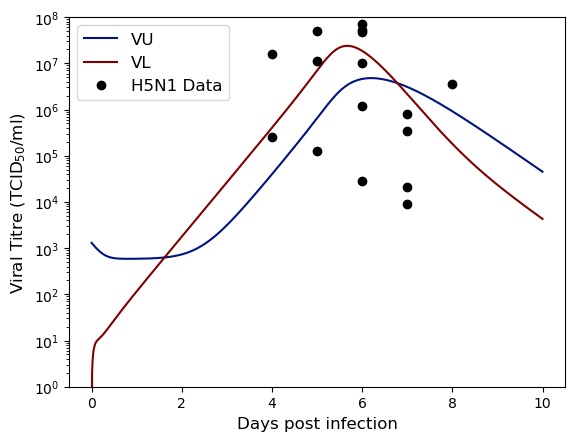

Objective: 60.42219876538503
Parameters: [2.43874764e-07 3.91314153e-07 4.00182583e+00 1.98605258e+00
 5.20159694e+00 1.35701397e-01 9.38621021e-02 5.00000000e-03
 1.99925735e+01 1.17130445e-09 3.90208766e-02 1.53312259e-01
 2.71548433e-01]


In [84]:
x0 = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/Cell_Count_U, 5e7/Cell_Count_L, 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]
testel = least_squares(everything_log_minimiser_vu, x0,bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testel.x
p = theta
p[7] = 0.005
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testel.cost}")
print(f"Parameters: {testel.x}")

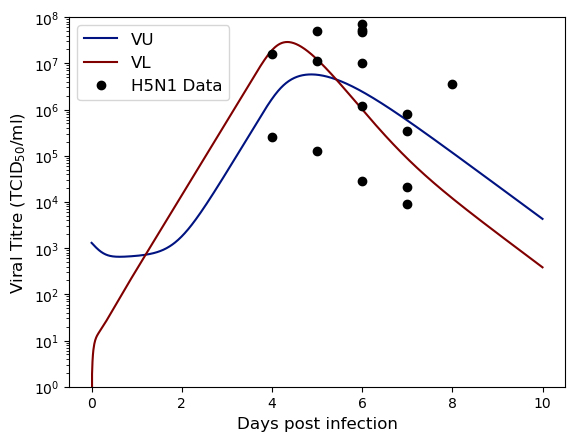

Objective: 60.42219876538503
Parameters: [2.43874764e-07 3.91314153e-07 4.00182583e+00 1.98605258e+00
 5.20159694e+00 1.35701397e-01 9.38621021e-02 3.00879909e-03
 1.99925735e+01 1.17130445e-09 3.90208766e-02 1.53312259e-01
 2.71548433e-01]


In [85]:
x0 = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/Cell_Count_U, 5e7/Cell_Count_L, 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]
testel = least_squares(everything_log_minimiser_vu, x0,bounds=(0,np.inf))
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testel.x
p = theta
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testel.cost}")
print(f"Parameters: {testel.x}")

In [61]:
diff = testel.x - x0
print(f"b_u: {diff[0]/x0[0]}, b_l: {diff[1]/x0[1]}, g: {diff[2]/x0[2]}, c: {diff[3]/x0[3]}, d: {diff[4]/x0[4]}, p_u: {diff[5]/x0[5]}, p_l: {diff[6]/x0[6]}, gamma: {diff[7]/x0[7]}, k: {diff[8]/x0[8]}, f: {diff[9]/x0[9]}, r: {diff[10]/x0[10]}, D: {diff[11]/x0[11]}, a: {diff[12]/x0[12]}")

b_u: 15.258317600879462, b_l: -0.7391238982113171, g: 0.000456457838983404, c: -0.006973711989727183, d: 0.0003071045685147762, p_u: 0.08561117590520917, p_l: 10.732762761891674, gamma: inf, k: -0.00037132370294283844, f: -0.9947709622990285, r: 0.011652355848398365, D: 14.331225908141203, a: 1.71548433369088


/tmp/ipykernel_134563/2357462725.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"b_u: {diff[0]/x0[0]}, b_l: {diff[1]/x0[1]}, g: {diff[2]/x0[2]}, c: {diff[3]/x0[3]}, d: {diff[4]/x0[4]}, p_u: {diff[5]/x0[5]}, p_l: {diff[6]/x0[6]}, gamma: {diff[7]/x0[7]}, k: {diff[8]/x0[8]}, f: {diff[9]/x0[9]}, r: {diff[10]/x0[10]}, D: {diff[11]/x0[11]}, a: {diff[12]/x0[12]}")
